In [1]:
# import statements
import sys
sys.path.append('..')

import deepxde as dde
import f90nml
import numpy as np
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
from QLCstuff2 import getNQLL
import reference_solution as refsol
from scipy.fft import rfft  #, irfft
import tensorflow as tf

# must run code twice for it to actually use this backend if it has to switch
dde.backend.set_default_backend("tensorflow")
dde.config.set_default_float("float32")

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Set the default float type to float32


In [2]:
# Read in GI parameters
inputfile = "GI parameters - Reference limit cycle (for testing).nml"
GI=f90nml.read(inputfile)['GI']
nx_crystal = GI['nx_crystal']
L = GI['L']
D = GI['D']
D_units = GI['D_units']
D = AssignQuantity(D,D_units)# Compute Nqll_eq
NBAR = GI['Nbar']
NSTAR = GI['Nstar']

# Define x values for plotting
X_QLC = np.linspace(-L,L,nx_crystal)

# Define t range
RUNTIME = 5
NUM_T_STEPS = RUNTIME + 1

# Define initial conditions
Ntot_init_1D = np.ones(nx_crystal)
Nqll_init_1D = getNQLL(Ntot_init_1D,NSTAR,NBAR)

In [3]:
# Define geometry
geom = dde.geometry.Interval(-L, L)
timedomain = dde.geometry.TimeDomain(0, RUNTIME)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Ntot and Nqll start at 1 when t=0
@tf.autograph.experimental.do_not_convert
def initial_condition(x):
    return 1.0

# Initial condition is applied to all points where t=0
@tf.autograph.experimental.do_not_convert
def on_initial(x, on_initial):
    return on_initial

# Ntot and Nqll start at 1 for all (x, t) when t=0
ic1 = dde.icbc.IC(geomtime, initial_condition, on_initial, component=0)
ic2 = dde.icbc.IC(geomtime, initial_condition, on_initial, component=1)

In [4]:
def f1d_solve_ivp_dimensionless(Ntot, Nqll, dNqll_dxx, scalar_params, sigmaI):
    """
    Adapted from QLCstuff2, this function computes the right-hand side of
    the two objective functions that make up the QLC system.
    
    Returns:
        [dNtot_dt, dNqll_dt]
    """
    sigma0, omega_kin = scalar_params

    # Diffusion term based on FT
    # Dcoefficient1 = np.pi**2 / (L)**2  
    # bj_list = rfft(Nqll)
    # cj_list = bj_list*J2_LIST
    # dy = -Dcoefficient1 * irfft(cj_list)    # This is actually a second derivative...

    # Ntot deposition
    m = (Nqll - (NBAR - NSTAR))/(2*NSTAR)
    sigma_m = (sigmaI - m * sigma0)
    dNtot_dt = omega_kin * sigma_m
    dNtot_dt += dNqll_dxx

    # NQLL    
    dNqll_dt = dNtot_dt - (Nqll - (NBAR - NSTAR*tf.sin(2*np.pi*Ntot)))
    
    # Package for output
    return dNtot_dt, dNqll_dt

In [5]:
def QLC_model(xs, ys):
    """Defines QLC model. Acts as collocation point loss function.

    Args:
        xs: xs[0] = x, xs[1] = t
        ys: ys[0] = Ntot, ys[1] = Nqll

    Returns:
        [Ntot-loss, Nqll-loss]

    """
    Ntot, Nqll = ys[:, 0:1], ys[:, 1:]
    
    # Compute gradients
    dNtot_dt = dde.grad.jacobian(ys, xs, i=0, j=1)
    dNqll_dt = dde.grad.jacobian(ys, xs, i=1, j=1)
    dNqll_dxx = dde.grad.hessian(ys, xs, i=1, j=0)

    # Supersaturation reduction at center
    c_r = GI['c_r']

    # Thickness of monolayers
    h_pr = GI['h_pr']
    h_pr_units = GI['h_pr_units']
    h_pr = AssignQuantity(h_pr,h_pr_units)
    h_pr.ito('micrometer')

    # Deposition velocity
    nu_kin = GI['nu_kin']
    nu_kin_units = GI['nu_kin_units']
    nu_kin = AssignQuantity(nu_kin,nu_kin_units)

    # Difference in equilibrium supersaturation between microsurfaces I and II
    sigma0 = GI['sigma0']

    # Supersaturation at facet corner
    sigmaI_corner = GI['sigmaI_corner']

    # Time constant for freezing/thawing
    tau_eq = GI['tau_eq']
    tau_eq_units = GI['tau_eq_units']
    tau_eq = AssignQuantity(tau_eq,tau_eq_units)

    # Compute omega_kin
    nu_kin_mlyperus = nu_kin/h_pr
    nu_kin_mlyperus.ito('1/microsecond')
    omega_kin = nu_kin_mlyperus.magnitude * tau_eq.magnitude

    # Compute sigmaI
    sigmaI = sigmaI_corner*(c_r*(X_QLC/L)**2+1-c_r)
    
    # Nbar, Nstar, sigma0, omega_kin, deltax = scalar_params
    scalar_params = np.asarray([sigma0, omega_kin])

    dNtot_dt_rhs, dNqll_dt_rhs = f1d_solve_ivp_dimensionless(Ntot, Nqll, dNqll_dxx, scalar_params, sigmaI)

    # Return [Ntot-loss, Nqll-loss]
    return [dNtot_dt - dNtot_dt_rhs, # dNtot_dt = Nqll*surface_diff_coefficient + w_kin*sigma_m
            dNqll_dt - dNqll_dt_rhs] # dNqll_dt = dNtot/dt - (Nqll - Nqll_eq)

In [6]:
# Define PDE problem
data = dde.data.TimePDE(
    geomtime,
    QLC_model,
    [ic1, ic2],
    num_domain=20_000,
    num_initial=500,
    train_distribution="pseudo",
    anchors=None,
)

# Create point resampling callback
resampler = dde.callbacks.PDEPointResampler(period=1)

# Define layer sizes
layers = [2] + 8*[80] + [2]

# Define activations for each layer (input layer has no activation)
activations = ['sin'] + 7*['tanh'] + [None]

# Define NN architechture and model
net = dde.nn.FNN(layers, activations, 'He uniform')
model = dde.Model(data, net)

# Compile with Adam optimizer LR=0.001
model.compile(
    optimizer="adam",
    lr=0.001,
    loss="MSE",
    # decay=("inverse time", 1000, 0.95),
)

print("Don't forget to change model_name! Don't overwrite previous models!")

# Train on Adam
losshistory, train_state = model.train(iterations=5_000, display_every=200, callbacks=[resampler])

# Compile and train on L-BFGS
dde.optimizers.set_LBFGS_options(gtol=1e-8, maxiter=5_000)
model.compile("L-BFGS")
losshistory, train_state = model.train(display_every=100, callbacks=[resampler])

Compiling model...
'compile' took 0.000287 s

Don't forget to change model_name! Don't overwrite previous models!
Training model...



c:\jonescode\icecontinuum\2024 - Jones, Branson\ice_venv\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer HeUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Step      Train loss                                  Test loss                                   Test metric
0         [1.34e+00, 5.20e+00, 1.08e+00, 2.83e+00]    [1.34e+00, 5.20e+00, 1.08e+00, 2.83e+00]    []  
200       [2.52e-03, 3.06e-03, 3.65e-04, 3.90e-04]    [2.76e-03, 3.36e-03, 3.65e-04, 3.90e-04]    []  
400       [1.18e-03, 1.09e-03, 8.23e-05, 1.94e-04]    [1.24e-03, 1.19e-03, 8.23e-05, 1.94e-04]    []  
600       [9.29e-04, 7.50e-04, 3.83e-05, 1.00e-04]    [9.02e-04, 6.69e-04, 3.83e-05, 1.00e-04]    []  
800       [7.29e-04, 4.59e-04, 4.75e-05, 7.19e-05]    [7.57e-04, 4.40e-04, 4.75e-05, 7.19e-05]    []  
1000      [6.98e-04, 3.63e-04, 1.75e-04, 1.64e-04]    [6.70e-04, 3.83e-04, 1.75e-04, 1.64e-04]    []  
1200      [6.56e-04, 2.88e-04, 3.37e-05, 3.51e-05]    [6.15e-04, 2.70e-04, 3.37e-05, 3.51e-05]    []  
1400      [6.06e-04, 2.87e-04, 2.97e-05, 3.11e-05]    [5.88e-04, 2.37e-04, 2.97e-05, 3.11e-05]    []  
1600      [5.71e-04, 2.34e-04, 3.37e-05, 4.36e-05]    [5.53e-04, 2

INFO:tensorflow:Assets written to: ice_pinns\100k_tp\assets


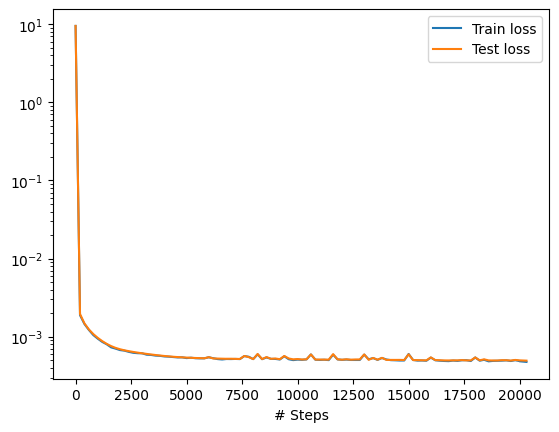

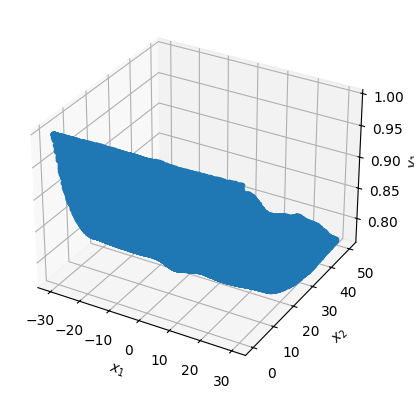

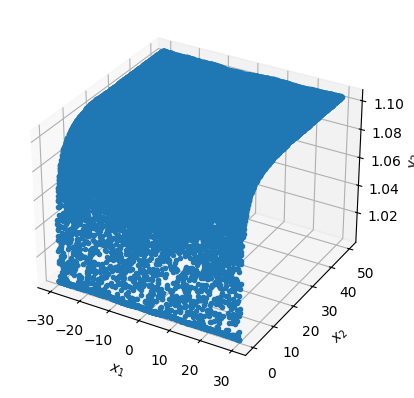

In [ ]:
# Save the model as a directory ./model_name/
keras_model = model.net
model_name = "ice_pinns\\sin_t5_80wide"
tf.keras.models.save_model(keras_model, model_name, include_optimizer=False, save_format="tf")

# Plot
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

Plots

Using parameter file GI parameters - Reference limit cycle (for testing).nml ...

This is a run from time 0.0 millisecond to 50.0 millisecond
dt = 1000.0 microsecond
50 % elapsed time is 0.036 minutes
60 % elapsed time is 0.043 minutes
70 % elapsed time is 0.050 minutes
80 % elapsed time is 0.057 minutes
90 % elapsed time is 0.064 minutes
100% done
status =  0
message =  The solver successfully reached the end of the integration interval.
['message', 'nfev', 'njev', 'nlu', 'sol', 'status', 'success', 't', 't_events', 'y', 'y_events']


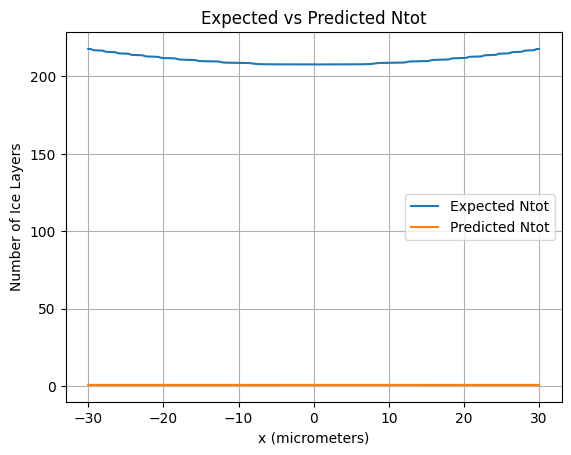

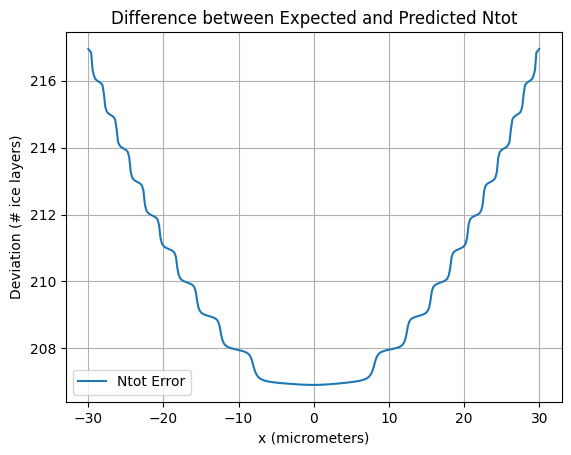

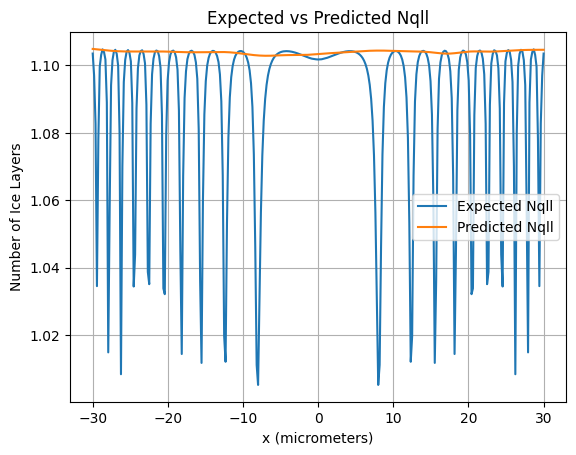

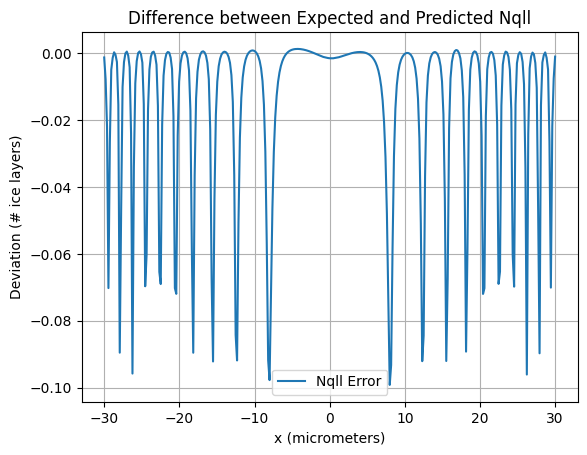

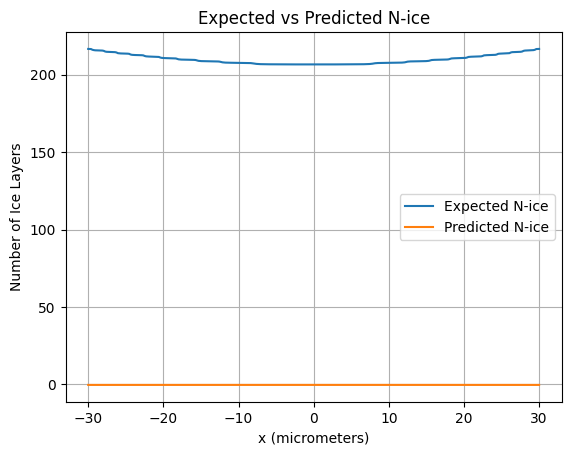

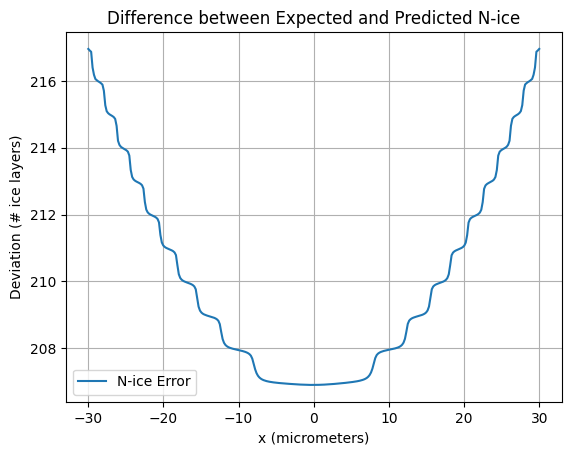

In [ ]:
# Define x and t points
# X_QLC defined above
t_points = np.linspace(0, RUNTIME, NUM_T_STEPS)
x, t = np.meshgrid(X_QLC, t_points)
x_flat = x.flatten()
t_flat = t.flatten()

# Create the input array for the network
input_points = np.vstack((x_flat, t_flat)).T

# Get predictions from the network
pred = model.predict(input_points)
Ntot_pred = pred[:, 0].reshape((NUM_T_STEPS, 320))
Nqll_pred = pred[:, 1].reshape((NUM_T_STEPS, 320))
Nice_pred = Ntot_pred - Nqll_pred

# Stack predictions to match expected output shape
network_solution = np.stack([Ntot_pred, Nqll_pred, Nice_pred], axis=0)

# Generate expected output
reference_solution = refsol.generate_reference_solution(runtime=RUNTIME, num_steps=NUM_T_STEPS)

# Plot reference solution vs network output
refsol.plot_reference_vs_network(reference_solution, network_solution)